In [2]:
import pandas as pd
import os
from nltk.corpus import stopwords
import nltk.data
import logging, bz2
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup
import re
import gensim
from gensim.models.keyedvectors import KeyedVectors
from sklearn.cluster import KMeans
import time
from gensim import corpora
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import sklearn
print ("Done")

C:\Users\Juilee Rege\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Done


In [3]:
## All helper functions
def review_to_wordlist( review, remove_stopwords=False ):
    review_text = BeautifulSoup(review,"lxml").get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return(words)

def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append( review_to_wordlist( raw_sentence, remove_stopwords ))
    return sentences

def create_bag_of_centroids( wordlist, word_centroid_map ):
    num_centroids = max( word_centroid_map.values() ) + 1
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    return bag_of_centroids

In [4]:
# Reading data from files
train = pd.read_csv( "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

print ("Read %d labeled train reviews, %d labeled test reviews, " \
     "and %d unlabeled reviews\n" % (train["review"].size,
     test["review"].size, unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [41]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = []
print ("Parsing sentences from training set")
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)
print ("")
print ("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

print ("Length of sentences: ",len(sentences))

with open('pickle_sentences', 'wb') as handle:
    pickle.dump(sentences, handle, protocol=pickle.HIGHEST_PROTOCOL)

Parsing sentences from training set


C:\Users\Juilee Rege\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\Juilee Rege\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\Juilee Rege\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup



Parsing sentences from unlabeled set


C:\Users\Juilee Rege\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Juilee Rege\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Juilee Rege\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'... ...'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:

Length of sentences:  795538


The following cell creates a Word2Vec model which will be used to vectorize each of the movie posts in the data set. The model has parameters such as context = 5, embedding dimension = 100, min_words = 40. Z1 stores the feature vectors for every word in the vocabulary and will be used to vectorize the posts later on. Word2Vec is a 2 layer neural net that processes text and converts it to numerical form. Moreover, since it is an unsupervised learning technique, both labeled and unlabeled reviews can be passed to it to create the training set, thus more training data can be used and nothing is wasted.

In [42]:
# 1a) creating Z1
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
num_features = 100    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

print ("Training Word2Vec model...")
model1 = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling, seed=1)
model1.init_sims(replace=True)
model1_name = "100features_40minwords_5context"
model1.save(model1_name)
print ("Done training model1")

Z1 = (model1.wv.syn0)
print ("Z1 shape: ",Z1.shape)

2017-04-14 12:06:54,252 : INFO : collecting all words and their counts
2017-04-14 12:06:54,253 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-14 12:06:54,326 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2017-04-14 12:06:54,364 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types
2017-04-14 12:06:54,441 : INFO : PROGRESS: at sentence #30000, processed 671315 words, keeping 30034 word types
2017-04-14 12:06:54,479 : INFO : PROGRESS: at sentence #40000, processed 897815 words, keeping 34348 word types


Training Word2Vec model...


2017-04-14 12:06:54,556 : INFO : PROGRESS: at sentence #50000, processed 1116963 words, keeping 37761 word types
2017-04-14 12:06:54,616 : INFO : PROGRESS: at sentence #60000, processed 1338404 words, keeping 40723 word types
2017-04-14 12:06:54,675 : INFO : PROGRESS: at sentence #70000, processed 1561580 words, keeping 43333 word types
2017-04-14 12:06:54,729 : INFO : PROGRESS: at sentence #80000, processed 1780887 words, keeping 45714 word types
2017-04-14 12:06:54,806 : INFO : PROGRESS: at sentence #90000, processed 2004996 words, keeping 48135 word types
2017-04-14 12:06:54,864 : INFO : PROGRESS: at sentence #100000, processed 2226966 words, keeping 50207 word types
2017-04-14 12:06:54,925 : INFO : PROGRESS: at sentence #110000, processed 2446580 words, keeping 52081 word types
2017-04-14 12:06:54,984 : INFO : PROGRESS: at sentence #120000, processed 2668775 words, keeping 54119 word types
2017-04-14 12:06:55,036 : INFO : PROGRESS: at sentence #130000, processed 2894303 words, keep

2017-04-14 12:06:58,882 : INFO : PROGRESS: at sentence #770000, processed 17217759 words, keeping 121703 word types
2017-04-14 12:06:58,964 : INFO : PROGRESS: at sentence #780000, processed 17447905 words, keeping 122402 word types
2017-04-14 12:06:59,004 : INFO : PROGRESS: at sentence #790000, processed 17674981 words, keeping 123066 word types
2017-04-14 12:06:59,059 : INFO : collected 123504 word types from a corpus of 17798082 raw words and 795538 sentences
2017-04-14 12:06:59,061 : INFO : Loading a fresh vocabulary
2017-04-14 12:06:59,166 : INFO : min_count=40 retains 16490 unique words (13% of original 123504, drops 107014)
2017-04-14 12:06:59,166 : INFO : min_count=40 leaves 17238940 word corpus (96% of original 17798082, drops 559142)
2017-04-14 12:06:59,242 : INFO : deleting the raw counts dictionary of 123504 items
2017-04-14 12:06:59,248 : INFO : sample=0.001 downsamples 48 most-common words
2017-04-14 12:06:59,248 : INFO : downsampling leaves estimated 12749658 word corpus 

2017-04-14 12:08:06,944 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-04-14 12:08:06,952 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-04-14 12:08:06,960 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-04-14 12:08:06,965 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-04-14 12:08:06,966 : INFO : training on 88990410 raw words (63746085 effective words) took 67.3s, 947781 effective words/s
2017-04-14 12:08:06,967 : INFO : precomputing L2-norms of word weight vectors
2017-04-14 12:08:07,149 : INFO : saving Word2Vec object under 100features_40minwords_5context, separately None
2017-04-14 12:08:07,149 : INFO : not storing attribute syn0norm
2017-04-14 12:08:07,149 : INFO : not storing attribute cum_table
2017-04-14 12:08:07,449 : INFO : saved 100features_40minwords_5context


Done training model1
Z1 shape:  (16490, 100)


The following cell downloads the pre-trained Google Word2Vec model. This will be used to vectorize the movie posts. The vocabulary in this model is extremely huge. Z2 is storing this. The shape of Z2 is (3000000, 300). Using this model as it is will be very computationally expensive so the workaround was to filter out the words which did not occur as part of the movie posts. This would reduce the vocabulary to a great extent as the movie posts are much lesser in number. However, this would result in reduction of accuracy of the model performance. Since I had ample time to let my models work, I decided to continue using the pre-trained model as it is.

In [18]:
# 1b) Creating Z2
model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
model2_name = "google_model"
model2.save(model2_name)
print ("Done training model2")

Z2 = (model2.syn0)
print ("Z2 shape: ",Z2.shape)

Done training model2
Z2 shape:  (3000000, 300)


The following cell performs Kmeans clustering on Z1 using 10 clusters. I do agree that using this less number of clusters in comparison to the size of the vocabulary would result in diverse words appearing in a cluster and thus not showing very accurate results of similarity between words but I had performed this much before the requirements of the assignment changed and so I decided to continue with 10 clusters. On printing the top 20 words from each cluster, some patterns can be seen.

Cluster 3 has many war related words such as 'province', 'horsemen', 'armies', 'escaping', 'leadership', 'frontier', 'mission'.

Cluster 4 is made up of names such as 'riley', 'audrey', 'rudolph', 'yvette', 'sue', 'sharma', 'becky', 'edwin', stella'.

In [15]:
# 1c) performing KMeans clustering on Z1
start = time.time()
km1 = KMeans(n_clusters=10)
idx1 = km1.fit_predict(Z1)
end = time.time()
elapsed = end - start
print ("Time taken for K Means clustering of Z1: ", elapsed)

with open('pickle_idx1', 'wb') as handle:
    pickle.dump(idx1, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("")
print ("Top 20 words in each cluster for Z1")
word_centroid_map1 = dict(zip( model1.wv.index2word, idx1))
for cluster in range(0,10):
    print ("Cluster #",(cluster+1))
    words1 = []
    for key, item in word_centroid_map1.items():
        if(item==cluster):
            words1.append(key)
    print (words1[0:20])
    print ("")
print ("Done")


Time taken for K Means clustering of Z1:  8.762932777404785

Top 20 words in each cluster for Z1
Cluster # 1
['experience', 'formula', 'f', 'voting', 'viewing', 'chills', 'sound', 'downhill', 'dud', 'bucks', 'click', 'going', 'making', 'renting', 'mine', 'cringe', 'uk', 'apart', 'was', 'instantly']

Cluster # 2
['attacked', 'fills', 'prone', 'corrupted', 'learned', 'shocked', 'departed', 'finishes', 'accepted', 'botched', 'seeking', 'showcased', 'controlling', 'dominates', 'sending', 'followed', 'dragged', 'threw', 'prompted', 'fits']

Cluster # 3
['province', 'horsemen', 'armies', 'nurses', 'escaping', 'boarding', 'leadership', 'wisconsin', 'regions', 'trial', 'cylon', 'flown', 'frontier', 'personnel', 'turks', 'slum', 'mission', 'confinement', 'occurring', 'robots']

Cluster # 4
['riley', 'brennan', 'van', 'audrey', 'linklater', 'clay', 'rudolph', 'yvette', 'peel', 'sue', 'sharma', 'becky', 'reportedly', 'edwin', 'ki', 'stella', 'zelah', 'silverman', 'raoul', 'cooper']

Cluster # 5
[

The following cell performs Kmeans clustering on Z2 using 10 clusters. This clustering will perform even worse in detecting word similarity due to the extremely large vocabulary space. I have printed the top 20 words from each cluster below.

In [19]:
# 1c continued) performing KMeans clustering on Z2
start = time.time()
idx2 = KMeans(n_clusters=10).fit_predict(Z2)
end = time.time()
elapsed = end - start

with open('pickle_idx2', 'wb') as handle:
    pickle.dump(idx2, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("")
print ("Top 20 words in each cluster for Z2")
word_centroid_map2 = dict(zip(model2.index2word, idx2))
for cluster in range(0,10):
    print ("Cluster #",(cluster+1))
    words2 = []
    for key, item in word_centroid_map2.items():
        if(item==cluster):
            words2.append(key)
    print (words2[0:20])
    print ("")
print ("Done")


Top 20 words in each cluster for Z2
Cluster # 1
['Prosecuting_Officer', 'Bhal', 'Minister_Sibu_Soren', 'Indias', 'Foreign_Affairs_Zainul_Abidin', 'Prasanna', 'nepal', 'Kirundi', 'Kuttab', 'abadi', 'Shahid_Hayat', 'quacks', 'Abi_Mahmoud', 'Yinchuan', 'Hillary_Onek', 'ISODEC', 'Bangalore_serial_blasts', 'Nsawam_Medium_Security', 'Ohr_Avner_Chabad', 'Malayan_Banking_Bhd_Maybank']

Cluster # 2
['Roaming_Shores', 'Simkin', 'Tazewell_County', 'Kitayama', 'Feder', 'UAA_##:##.#', 'Courcelle', 'Heathershaw', 'Nesiba', 'Visconti', 'Langhorne_Pa.', 'Lyke', 'Waldschlager', 'McBrearty', 'Cavendar', 'Marcella', 'powder_puff_football', 'Haytaian', 'SHINE_counselor', 'Savain']

Cluster # 3
['Tekkeon', 'transgenics', 'lightwaves', 'BC_SeraPro', 'Renal_Transplant', 'ammonium_phosphate', 'transmission_solenoids', 'Coating_Technologies', 'provides_dermal_analgesia', 'LaRC', 'nimesulide', 'cumene', 'dihydrocapsiate', 'fibrous_tissue', 'BLAS', 'bioterror', 'nanotube_coating', 'Stumpjumper', 'electromagneti

In [46]:
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append( review_to_wordlist( review, remove_stopwords=True ))
with open('pickle_clean_train', 'wb') as handle:
    pickle.dump(clean_train_reviews, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
clean_unlabeled_reviews = []
for review in unlabeled_train["review"]:
    clean_unlabeled_reviews.append( review_to_wordlist( review, remove_stopwords=True ))
with open('pickle_clean_unlabeled', 'wb') as handle:
    pickle.dump(clean_unlabeled_reviews, handle, protocol=pickle.HIGHEST_PROTOCOL)

clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append( review_to_wordlist( review, remove_stopwords=True ))
with open('pickle_clean_test', 'wb') as handle:
    pickle.dump(clean_test_reviews, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print ("Done")

Done


The following cell vectorizes the movie posts using both Z1 and Z2 models to create X1 and X2. Basically a vector for each review will be of length 10 (number of clusters) and will indicate how many of the words of each cluster appear in that review. This is done using bag of centroids method where the reviews are initially cleaned and then compared with the centroid maps created of each model.

In [47]:
# 1d) creating X1 and X2
X1 = np.zeros( (train["review"].size, 10), dtype="float32" )
counter = 0
for review in clean_train_reviews:
    X1[counter] = create_bag_of_centroids( review, word_centroid_map1 )
    counter += 1
with open('pickle_X1', 'wb') as handle:
    pickle.dump(X1, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
X2 = np.zeros( (train["review"].size, 10), dtype="float32" )
counter = 0
for review in clean_train_reviews:
    X2[counter] = create_bag_of_centroids( review, word_centroid_map2 )
    counter += 1
with open('pickle_X2', 'wb') as handle:
    pickle.dump(X2, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("Done")

Done


The following cell performs LDA topic modelling on the movie posts data set. LDA stands for Latent Dirichlet Allocation and is a way of automatically detecting topics that the text might contain. It represents text as a mixture of topics that output words with certain probabilities. The first model is create using number of topics = 10. An initial dictionary and corpus is created and then an lda model is trained. Using this model, the movie posts are vectorized to create X3.

In [48]:
# 2a) LDA Topic Modeling with n_topics = 10
clean_reviews = clean_train_reviews + clean_unlabeled_reviews

dictionary1 = corpora.Dictionary(clean_reviews)
corpus1 = [dictionary1.doc2bow(cr) for cr in clean_reviews]
ldamodel1 = gensim.models.ldamodel.LdaModel(corpus1, num_topics = 10, id2word = dictionary1)

X3 = np.zeros((train['review'].size, 10), dtype="float32")
revSize1 = 0
for ctr in clean_train_reviews:
    vec1 = dictionary1.doc2bow(ctr)
    doc_lda1 = ldamodel1[vec1]
    for i in range(0,len(doc_lda1)):
        point1 = doc_lda1[i][0]
        X3[revSize1][point1] = doc_lda1[i][1]
    revSize1+=1

with open('pickle_X3', 'wb') as handle:
    pickle.dump(X3, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ("Done")

2017-04-14 12:14:30,642 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-04-14 12:14:32,815 : INFO : adding document #10000 to Dictionary(51374 unique tokens: ['shantytowns', 'dishing', 'coherence', 'sinny', 'inscriptions']...)
2017-04-14 12:14:34,774 : INFO : adding document #20000 to Dictionary(67660 unique tokens: ['shantytowns', 'dishing', 'coherence', 'sinny', 'inscriptions']...)
2017-04-14 12:14:36,525 : INFO : adding document #30000 to Dictionary(81517 unique tokens: ['shantytowns', 'dishing', 'coherence', 'sinny', 'inscriptions']...)
2017-04-14 12:14:38,323 : INFO : adding document #40000 to Dictionary(93236 unique tokens: ['shantytowns', 'sinny', 'kerrigans', 'columbians', 'bertrams']...)
2017-04-14 12:14:40,184 : INFO : adding document #50000 to Dictionary(103321 unique tokens: ['shantytowns', 'daala', 'sinny', 'kerrigans', 'hridaynath']...)
2017-04-14 12:14:41,963 : INFO : adding document #60000 to Dictionary(112022 unique tokens: ['winnetou', 'shantytowns

2017-04-14 12:15:25,771 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-04-14 12:15:26,503 : INFO : topic #5 (0.100): 0.010*"like" + 0.010*"film" + 0.009*"movie" + 0.008*"one" + 0.006*"bad" + 0.005*"even" + 0.004*"time" + 0.004*"would" + 0.004*"see" + 0.004*"good"
2017-04-14 12:15:26,506 : INFO : topic #3 (0.100): 0.013*"film" + 0.012*"one" + 0.005*"good" + 0.004*"films" + 0.004*"great" + 0.004*"see" + 0.004*"well" + 0.003*"time" + 0.003*"years" + 0.003*"life"
2017-04-14 12:15:26,509 : INFO : topic #0 (0.100): 0.031*"film" + 0.006*"one" + 0.005*"story" + 0.005*"movie" + 0.005*"life" + 0.004*"also" + 0.004*"well" + 0.004*"see" + 0.003*"like" + 0.003*"people"
2017-04-14 12:15:26,512 : INFO : topic #2 (0.100): 0.046*"movie" + 0.012*"one" + 0.010*"like" + 0.009*"really" + 0.009*"good" + 0.008*"film" + 0.007*"bad" + 0.007*"movies" + 0.007*"time" + 0.006*"see"
2017-04-14 12:15:26,515 : INFO : topic #8 (0.100): 0.006*"one" + 0.006*"would" + 0.006*"movie" + 0.

2017-04-14 12:16:01,278 : INFO : topic #2 (0.100): 0.049*"movie" + 0.012*"one" + 0.011*"like" + 0.011*"good" + 0.010*"really" + 0.010*"film" + 0.008*"movies" + 0.008*"bad" + 0.007*"see" + 0.007*"even"
2017-04-14 12:16:01,281 : INFO : topic #7 (0.100): 0.014*"show" + 0.008*"one" + 0.008*"series" + 0.008*"like" + 0.006*"good" + 0.006*"would" + 0.005*"time" + 0.005*"episode" + 0.005*"even" + 0.005*"great"
2017-04-14 12:16:01,290 : INFO : topic diff=0.334494, rho=0.288675
2017-04-14 12:16:01,293 : INFO : PROGRESS: pass 0, at document #26000/75000
2017-04-14 12:16:04,442 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-04-14 12:16:05,104 : INFO : topic #0 (0.100): 0.033*"film" + 0.007*"story" + 0.006*"one" + 0.005*"well" + 0.005*"life" + 0.004*"films" + 0.004*"also" + 0.004*"movie" + 0.004*"see" + 0.004*"characters"
2017-04-14 12:16:05,104 : INFO : topic #6 (0.100): 0.020*"film" + 0.009*"movie" + 0.008*"like" + 0.008*"one" + 0.006*"people" + 0.006*"story" + 

2017-04-14 12:16:28,355 : INFO : topic #9 (0.100): 0.007*"one" + 0.005*"role" + 0.004*"film" + 0.004*"best" + 0.003*"plays" + 0.003*"comedy" + 0.003*"cast" + 0.003*"well" + 0.003*"like" + 0.003*"character"
2017-04-14 12:16:28,355 : INFO : topic #3 (0.100): 0.010*"one" + 0.009*"film" + 0.005*"family" + 0.004*"young" + 0.004*"old" + 0.004*"good" + 0.004*"great" + 0.003*"house" + 0.003*"also" + 0.003*"little"
2017-04-14 12:16:28,361 : INFO : topic #6 (0.100): 0.018*"film" + 0.008*"like" + 0.008*"movie" + 0.008*"one" + 0.007*"people" + 0.005*"would" + 0.005*"love" + 0.005*"story" + 0.005*"life" + 0.005*"way"
2017-04-14 12:16:28,363 : INFO : topic #8 (0.100): 0.010*"war" + 0.006*"people" + 0.005*"would" + 0.005*"world" + 0.005*"one" + 0.005*"movie" + 0.005*"american" + 0.004*"us" + 0.003*"documentary" + 0.003*"like"
2017-04-14 12:16:28,365 : INFO : topic #7 (0.100): 0.017*"show" + 0.010*"series" + 0.009*"one" + 0.008*"like" + 0.006*"good" + 0.006*"tv" + 0.006*"time" + 0.006*"great" + 0.006*

2017-04-14 12:17:01,053 : INFO : topic #3 (0.100): 0.009*"one" + 0.008*"film" + 0.005*"family" + 0.005*"young" + 0.005*"old" + 0.004*"house" + 0.003*"good" + 0.003*"jack" + 0.003*"great" + 0.003*"little"
2017-04-14 12:17:01,056 : INFO : topic #8 (0.100): 0.011*"war" + 0.006*"people" + 0.005*"world" + 0.005*"would" + 0.005*"american" + 0.005*"one" + 0.005*"movie" + 0.004*"us" + 0.003*"time" + 0.003*"documentary"
2017-04-14 12:17:01,067 : INFO : topic diff=0.268015, rho=0.200000
2017-04-14 12:17:01,070 : INFO : PROGRESS: pass 0, at document #52000/75000
2017-04-14 12:17:03,985 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-04-14 12:17:04,585 : INFO : topic #5 (0.100): 0.010*"like" + 0.009*"film" + 0.009*"one" + 0.007*"bad" + 0.006*"even" + 0.004*"movie" + 0.004*"get" + 0.004*"time" + 0.004*"would" + 0.004*"action"
2017-04-14 12:17:04,603 : INFO : topic #9 (0.100): 0.007*"one" + 0.006*"role" + 0.004*"film" + 0.004*"best" + 0.004*"plays" + 0.004*"cast" + 

2017-04-14 12:17:32,707 : INFO : PROGRESS: pass 0, at document #64000/75000
2017-04-14 12:17:35,579 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-04-14 12:17:36,149 : INFO : topic #9 (0.100): 0.007*"one" + 0.006*"role" + 0.004*"plays" + 0.004*"film" + 0.004*"cast" + 0.004*"best" + 0.004*"great" + 0.004*"john" + 0.004*"comedy" + 0.003*"character"
2017-04-14 12:17:36,154 : INFO : topic #3 (0.100): 0.009*"one" + 0.007*"film" + 0.005*"old" + 0.005*"family" + 0.005*"young" + 0.004*"house" + 0.004*"son" + 0.003*"mother" + 0.003*"father" + 0.003*"little"
2017-04-14 12:17:36,157 : INFO : topic #6 (0.100): 0.014*"film" + 0.008*"like" + 0.008*"people" + 0.007*"one" + 0.007*"movie" + 0.006*"life" + 0.006*"love" + 0.005*"would" + 0.005*"way" + 0.004*"character"
2017-04-14 12:17:36,159 : INFO : topic #7 (0.100): 0.021*"show" + 0.012*"series" + 0.009*"one" + 0.008*"tv" + 0.008*"like" + 0.007*"great" + 0.006*"time" + 0.006*"episode" + 0.006*"first" + 0.005*"would"


2017-04-14 12:18:00,455 : INFO : topic #5 (0.100): 0.009*"film" + 0.009*"like" + 0.008*"one" + 0.007*"bad" + 0.006*"even" + 0.004*"action" + 0.004*"get" + 0.004*"movie" + 0.004*"time" + 0.004*"plot"
2017-04-14 12:18:00,457 : INFO : topic #4 (0.100): 0.006*"one" + 0.005*"wife" + 0.005*"man" + 0.005*"film" + 0.004*"husband" + 0.004*"novel" + 0.004*"grant" + 0.004*"woman" + 0.004*"time" + 0.003*"version"
2017-04-14 12:18:00,460 : INFO : topic #7 (0.100): 0.021*"show" + 0.011*"series" + 0.009*"one" + 0.008*"like" + 0.008*"tv" + 0.007*"great" + 0.006*"time" + 0.006*"episode" + 0.006*"first" + 0.005*"would"
2017-04-14 12:18:00,469 : INFO : topic diff=0.188881, rho=0.162221


Done


The following cell also creates an LDA model but with number of topics = 20. The dataset is then vectorized using this model to create X4.

In [49]:
# 2b) LDA Topic Modeling with n_topics = 20
clean_reviews = clean_train_reviews + clean_unlabeled_reviews

dictionary2 = corpora.Dictionary(clean_reviews)
corpus2 = [dictionary2.doc2bow(cr) for cr in clean_reviews]
ldamodel2 = gensim.models.ldamodel.LdaModel(corpus2, num_topics = 20, id2word = dictionary2)

X4 = np.zeros((train['review'].size, 20), dtype="float32")
revSize2 = 0
for ctr in clean_train_reviews:
    vec2 = dictionary2.doc2bow(ctr)
    doc_lda2 = ldamodel2[vec2]
    for i in range(0,len(doc_lda2)):
        point2 = doc_lda2[i][0]
        X4[revSize2][point2] = doc_lda2[i][1]
    revSize2+=1
with open('pickle_X4', 'wb') as handle:
    pickle.dump(X4, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ("Done")

2017-04-14 12:19:42,344 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-04-14 12:19:44,161 : INFO : adding document #10000 to Dictionary(51374 unique tokens: ['shantytowns', 'dishing', 'coherence', 'sinny', 'inscriptions']...)
2017-04-14 12:19:46,130 : INFO : adding document #20000 to Dictionary(67660 unique tokens: ['shantytowns', 'dishing', 'coherence', 'sinny', 'inscriptions']...)
2017-04-14 12:19:47,830 : INFO : adding document #30000 to Dictionary(81517 unique tokens: ['shantytowns', 'dishing', 'coherence', 'sinny', 'inscriptions']...)
2017-04-14 12:19:49,584 : INFO : adding document #40000 to Dictionary(93236 unique tokens: ['shantytowns', 'sinny', 'kerrigans', 'columbians', 'bertrams']...)
2017-04-14 12:19:51,366 : INFO : adding document #50000 to Dictionary(103321 unique tokens: ['shantytowns', 'daala', 'sinny', 'kerrigans', 'hridaynath']...)
2017-04-14 12:19:53,156 : INFO : adding document #60000 to Dictionary(112022 unique tokens: ['winnetou', 'shantytowns

2017-04-14 12:20:47,183 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-04-14 12:20:48,251 : INFO : topic #11 (0.050): 0.030*"film" + 0.010*"one" + 0.007*"movie" + 0.005*"really" + 0.004*"like" + 0.004*"good" + 0.004*"well" + 0.004*"see" + 0.004*"films" + 0.004*"would"
2017-04-14 12:20:48,255 : INFO : topic #13 (0.050): 0.013*"film" + 0.007*"one" + 0.004*"story" + 0.004*"man" + 0.004*"character" + 0.004*"life" + 0.003*"good" + 0.003*"also" + 0.003*"young" + 0.003*"much"
2017-04-14 12:20:48,258 : INFO : topic #8 (0.050): 0.022*"film" + 0.012*"one" + 0.007*"story" + 0.006*"like" + 0.005*"time" + 0.004*"great" + 0.004*"good" + 0.004*"films" + 0.004*"well" + 0.004*"would"
2017-04-14 12:20:48,261 : INFO : topic #7 (0.050): 0.017*"film" + 0.009*"one" + 0.005*"well" + 0.005*"great" + 0.005*"story" + 0.005*"time" + 0.004*"movie" + 0.004*"good" + 0.004*"see" + 0.004*"game"
2017-04-14 12:20:48,264 : INFO : topic #6 (0.050): 0.014*"movie" + 0.008*"like" + 0.008*"

2017-04-14 12:21:28,404 : INFO : topic #18 (0.050): 0.010*"film" + 0.008*"one" + 0.005*"movie" + 0.005*"good" + 0.005*"like" + 0.004*"scenes" + 0.004*"first" + 0.004*"would" + 0.004*"action" + 0.004*"also"
2017-04-14 12:21:28,406 : INFO : topic #10 (0.050): 0.015*"film" + 0.007*"one" + 0.006*"love" + 0.005*"young" + 0.005*"role" + 0.004*"story" + 0.004*"man" + 0.004*"father" + 0.004*"performance" + 0.004*"novel"
2017-04-14 12:21:28,409 : INFO : topic #3 (0.050): 0.012*"show" + 0.011*"like" + 0.008*"episode" + 0.008*"series" + 0.008*"one" + 0.007*"first" + 0.006*"season" + 0.005*"time" + 0.005*"episodes" + 0.005*"funny"
2017-04-14 12:21:28,424 : INFO : topic diff=0.445758, rho=0.288675
2017-04-14 12:21:28,430 : INFO : PROGRESS: pass 0, at document #26000/75000
2017-04-14 12:21:32,190 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-04-14 12:21:33,024 : INFO : topic #15 (0.050): 0.010*"show" + 0.009*"one" + 0.008*"series" + 0.008*"film" + 0.006*"like" + 0

2017-04-14 12:21:56,111 : INFO : topic diff=0.429866, rho=0.235702
2017-04-14 12:21:56,117 : INFO : PROGRESS: pass 0, at document #38000/75000
2017-04-14 12:21:59,779 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-04-14 12:22:00,564 : INFO : topic #12 (0.050): 0.005*"one" + 0.005*"cop" + 0.004*"like" + 0.004*"police" + 0.004*"car" + 0.004*"opera" + 0.003*"well" + 0.003*"waters" + 0.003*"cops" + 0.003*"movie"
2017-04-14 12:22:00,564 : INFO : topic #5 (0.050): 0.027*"movie" + 0.014*"like" + 0.013*"bad" + 0.009*"one" + 0.009*"even" + 0.008*"get" + 0.008*"film" + 0.008*"would" + 0.007*"people" + 0.007*"really"
2017-04-14 12:22:00,581 : INFO : topic #2 (0.050): 0.012*"film" + 0.008*"like" + 0.007*"one" + 0.005*"comedy" + 0.004*"even" + 0.004*"movie" + 0.004*"king" + 0.004*"funny" + 0.003*"bad" + 0.003*"get"
2017-04-14 12:22:00,584 : INFO : topic #4 (0.050): 0.023*"film" + 0.016*"horror" + 0.011*"one" + 0.006*"films" + 0.006*"house" + 0.005*"story" + 0.004*

2017-04-14 12:22:38,721 : INFO : topic #13 (0.050): 0.008*"film" + 0.006*"one" + 0.006*"character" + 0.006*"man" + 0.005*"performance" + 0.004*"murder" + 0.004*"wife" + 0.004*"young" + 0.004*"well" + 0.003*"woman"
2017-04-14 12:22:38,737 : INFO : topic #15 (0.050): 0.009*"one" + 0.007*"show" + 0.007*"series" + 0.007*"comedy" + 0.005*"like" + 0.005*"funny" + 0.005*"film" + 0.005*"years" + 0.004*"characters" + 0.004*"british"
2017-04-14 12:22:38,740 : INFO : topic #16 (0.050): 0.005*"one" + 0.005*"de" + 0.005*"brooks" + 0.005*"karen" + 0.004*"film" + 0.004*"like" + 0.004*"songs" + 0.004*"murphy" + 0.004*"hopkins" + 0.003*"music"
2017-04-14 12:22:38,743 : INFO : topic #19 (0.050): 0.013*"film" + 0.011*"war" + 0.008*"world" + 0.008*"people" + 0.006*"american" + 0.006*"us" + 0.005*"documentary" + 0.005*"history" + 0.004*"one" + 0.004*"time"
2017-04-14 12:22:38,760 : INFO : topic diff=0.367771, rho=0.200000
2017-04-14 12:22:38,768 : INFO : PROGRESS: pass 0, at document #52000/75000
2017-04-1

2017-04-14 12:23:16,142 : INFO : topic #15 (0.050): 0.009*"one" + 0.008*"comedy" + 0.007*"show" + 0.006*"series" + 0.005*"funny" + 0.005*"years" + 0.005*"british" + 0.005*"like" + 0.004*"characters" + 0.004*"film"
2017-04-14 12:23:16,145 : INFO : topic #10 (0.050): 0.012*"film" + 0.008*"love" + 0.008*"role" + 0.007*"one" + 0.006*"young" + 0.005*"performance" + 0.005*"plays" + 0.004*"best" + 0.004*"great" + 0.004*"played"
2017-04-14 12:23:16,161 : INFO : topic diff=0.341089, rho=0.179605
2017-04-14 12:23:16,166 : INFO : PROGRESS: pass 0, at document #64000/75000
2017-04-14 12:23:19,864 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-04-14 12:23:20,542 : INFO : topic #6 (0.050): 0.009*"zombie" + 0.007*"bill" + 0.006*"zombies" + 0.006*"jim" + 0.006*"dead" + 0.005*"good" + 0.005*"kevin" + 0.005*"movie" + 0.005*"rock" + 0.005*"sam"
2017-04-14 12:23:20,542 : INFO : topic #7 (0.050): 0.017*"game" + 0.008*"western" + 0.008*"one" + 0.007*"prison" + 0.005*"film"

2017-04-14 12:23:47,660 : INFO : -8.876 per-word bound, 469.7 perplexity estimate based on a held-out corpus of 1000 documents with 118945 words
2017-04-14 12:23:47,660 : INFO : PROGRESS: pass 0, at document #75000/75000
2017-04-14 12:23:49,475 : INFO : merging changes from 1000 documents into a model of 75000 documents
2017-04-14 12:23:50,074 : INFO : topic #5 (0.050): 0.022*"movie" + 0.015*"like" + 0.011*"bad" + 0.010*"one" + 0.010*"even" + 0.009*"get" + 0.008*"would" + 0.008*"film" + 0.007*"people" + 0.007*"really"
2017-04-14 12:23:50,074 : INFO : topic #2 (0.050): 0.008*"film" + 0.007*"one" + 0.006*"like" + 0.006*"comedy" + 0.005*"funny" + 0.004*"even" + 0.004*"king" + 0.003*"man" + 0.003*"hilarious" + 0.003*"holmes"
2017-04-14 12:23:50,092 : INFO : topic #12 (0.050): 0.009*"cop" + 0.006*"opera" + 0.006*"police" + 0.005*"steve" + 0.005*"car" + 0.004*"waters" + 0.004*"vincent" + 0.004*"marie" + 0.004*"soap" + 0.003*"one"
2017-04-14 12:23:50,095 : INFO : topic #17 (0.050): 0.020*"fil

Done


In [50]:
# 2c) printing words for each topic from 2a
for i in range(0,10):
    l = ldamodel1.show_topic(i)
    print ("Topic ", (i+1))
    words = []
    for j in range(0,len(l)):
        words.append((l[j][0]))
    print (words)

Topic  1
['film', 'story', 'one', 'films', 'well', 'characters', 'life', 'also', 'many', 'much']
Topic  2
['film', 'horror', 'one', 'killer', 'also', 'death', 'man', 'two', 'blood', 'films']
Topic  3
['movie', 'one', 'like', 'good', 'film', 'really', 'bad', 'movies', 'see', 'would']
Topic  4
['one', 'film', 'old', 'young', 'family', 'jack', 'house', 'father', 'son', 'man']
Topic  5
['one', 'wife', 'man', 'film', 'husband', 'novel', 'grant', 'woman', 'time', 'version']
Topic  6
['film', 'like', 'one', 'bad', 'even', 'action', 'get', 'movie', 'time', 'plot']
Topic  7
['film', 'people', 'like', 'one', 'movie', 'life', 'love', 'would', 'way', 'get']
Topic  8
['show', 'series', 'one', 'like', 'tv', 'great', 'time', 'episode', 'first', 'would']
Topic  9
['war', 'people', 'world', 'american', 'would', 'one', 'movie', 'us', 'time', 'country']
Topic  10
['one', 'role', 'john', 'best', 'plays', 'cast', 'great', 'film', 'comedy', 'good']


In [51]:
# 2c continued) printing words for each topic from 2b
for i in range(0,20):
    l = ldamodel2.show_topic(i)
    print ("Topic ", (i+1))
    words = []
    for j in range(0,len(l)):
        words.append((l[j][0]))
    print (words)

Topic  1
['film', 'well', 'good', 'films', 'story', 'great', 'one', 'like', 'really', 'much']
Topic  2
['harry', 'water', 'horse', 'island', 'dinosaurs', 'victor', 'one', 'white', 'jaws', 'australian']
Topic  3
['film', 'one', 'like', 'comedy', 'funny', 'even', 'king', 'man', 'hilarious', 'holmes']
Topic  4
['series', 'episode', 'show', 'like', 'first', 'cartoon', 'one', 'season', 'episodes', 'funny']
Topic  5
['film', 'horror', 'one', 'killer', 'films', 'house', 'gore', 'blood', 'death', 'dead']
Topic  6
['movie', 'like', 'bad', 'one', 'even', 'get', 'would', 'film', 'people', 'really']
Topic  7
['zombie', 'bill', 'rock', 'jim', 'sam', 'zombies', 'john', 'kevin', 'dead', 'good']
Topic  8
['game', 'western', 'prison', 'one', 'bond', 'games', 'film', 'gun', 'play', 'james']
Topic  9
['one', 'film', 'sci', 'fi', 'time', 'space', 'earth', 'star', 'ship', 'charlie']
Topic  10
['movie', 'good', 'movies', 'one', 'like', 'really', 'acting', 'see', 'bad', 'story']
Topic  11
['film', 'role', 'o

The following cell trains 4 Random Forest classifiers using each of the 4 vectorized formats created before. Each of the X1-X4 matrices have been split into training and testing sets in an 80-20 manner. I have used trial and error to get the best performing model. Random Forests are basically collections of decision trees which perform better when applied as a collection. I have kept the number of trees as the testing parameter varying it from 5 to 100 in steps of 5. For each parameter, I am calculating the cross val score on the training data set also applying a cross validation of 5 to it. I am keeping a tally of the best cross val score seen till date and the corresponding number of trees. At the end, I am using the best performing parameter to re-train an RF classifier with the training data set and then test it on the testing dataset to get the values in order to plot the ROC curves for each classifier.

As seen in the figure, the 20 topics LDA model is performing the best with an AUC of 0.843 followed by the other LDA model. The Google pre-trained model is performing the worst.

In [7]:
# 3a) training 4 random forest classifiers M1, M2, M3, M4
with open("pickle_X1", "rb") as input_file:
   X1 = pickle.load(input_file)
with open("google_train_centroids.pickle", "rb") as input_file:
   X2 = pickle.load(input_file)
with open("pickle_X3", "rb") as input_file:
   X3 = pickle.load(input_file)
with open("pickle_X4", "rb") as input_file:
   X4 = pickle.load(input_file)

sen = train['sentiment']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, sen, test_size=0.2, random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, sen, test_size=0.2, random_state=0)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, sen, test_size=0.2, random_state=0)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, sen, test_size=0.2, random_state=0)

rf = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

##################################  first RF model ################
print ("First Model")
best_ras1 = -10
for r in rf:
    M1 = RandomForestClassifier(n_estimators = r)
    ras1 = 0.0
    scores1 = cross_val_score(M1, X1_train, y1_train, cv=5)
    ras1 = scores1.mean()
    print ("for ", r, " cross_val_score is: ", ras1)
    if(ras1>best_ras1):
        best_ras1 = ras1
        best_r1 = r
print ("best cross val score is: ", best_ras1)
print ("best r is: ", best_r1)
M1 = RandomForestClassifier(n_estimators = best_r1)
M1.fit(X1_train,y1_train)
predicted1 = M1.predict_proba(X1_test)
fpr1, tpr1, thresholds1 = roc_curve(y1_test, predicted1[:,1])
roc_auc1 = auc(fpr1,tpr1)

ans1 = M1.score(X1_test, y1_test)
print ("answer is : ", ans1)

##################################  second RF model ################
print ("Second Model")
best_ras2 = -10
for r in rf:
    M2 = RandomForestClassifier(n_estimators = r)
    ras2 = 0.0
    scores2 = cross_val_score(M2, X2_train, y2_train, cv=5)
    ras2 = scores2.mean()
    print ("for ", r, " cross_val_score is: ", ras2)
    if(ras2>best_ras2):
        best_ras2 = ras2
        best_r2 = r
print ("best cross val score is: ", best_ras2)
print ("best r is: ", best_r2)
M2 = RandomForestClassifier(n_estimators = best_r2)
M2.fit(X2_train,y2_train)
predicted2 = M2.predict_proba(X2_test)
fpr2, tpr2, thresholds2 = roc_curve(y2_test, predicted2[:,1])
roc_auc2 = auc(fpr2,tpr2)

ans2 = M2.score(X2_test, y2_test)
print ("answer is : ", ans2)

##################################  third RF model ################
print ("Third Model")
best_ras3 = -10
for r in rf:
    M3 = RandomForestClassifier(n_estimators = r)
    ras3 = 0.0
    scores3 = cross_val_score(M3, X3_train, y3_train, cv=5)
    ras3 = scores3.mean()
    print ("for ", r, " cross_val_score is: ", ras3)
    if(ras3>best_ras3):
        best_ras3 = ras3
        best_r3 = r
print ("best cross val score is: ", best_ras3)
print ("best r is: ", best_r3)
M3 = RandomForestClassifier(n_estimators = best_r3)
M3.fit(X3_train,y3_train)
predicted3 = M3.predict_proba(X3_test)
fpr3, tpr3, thresholds3 = roc_curve(y3_test, predicted3[:,1])
roc_auc3 = auc(fpr3,tpr3)

ans3 = M3.score(X3_test, y3_test)
print ("answer is : ", ans3)

##################################  fourth RF model ################
print ("Fourth Model")
best_ras4 = -10
for r in rf:
    M4 = RandomForestClassifier(n_estimators = r)
    ras4 = 0.0
    scores4 = cross_val_score(M4, X4_train, y4_train, cv=5)
    ras4 = scores4.mean()
    print ("for ", r, " cross_val_score is: ", ras4)
    if(ras4>best_ras4):
        best_ras4 = ras4
        best_r4 = r
print ("best cross val score is: ", best_ras4)
print ("best r is: ", best_r4)
M4 = RandomForestClassifier(n_estimators = best_r4)
M4.fit(X4_train,y4_train)
predicted4 = M4.predict_proba(X4_test)
fpr4, tpr4, thresholds4 = roc_curve(y4_test, predicted4[:,1])
roc_auc4 = auc(fpr4,tpr4)

ans4 = M4.score(X4_test, y4_test)
print ("answer is : ", ans4)

First Model
for  5  cross_val_score is:  0.570250640884
for  10  cross_val_score is:  0.587798729331
for  15  cross_val_score is:  0.595950442241
for  20  cross_val_score is:  0.597999342434
for  25  cross_val_score is:  0.603599642578
for  30  cross_val_score is:  0.607999067859
for  35  cross_val_score is:  0.611799480631
for  40  cross_val_score is:  0.608899667922
for  45  cross_val_score is:  0.609499680456
for  50  cross_val_score is:  0.612050043097
for  55  cross_val_score is:  0.616399793322
for  60  cross_val_score is:  0.613449418103
for  65  cross_val_score is:  0.615299993197
for  70  cross_val_score is:  0.612900005544
for  75  cross_val_score is:  0.614399893134
for  80  cross_val_score is:  0.619350305931
for  85  cross_val_score is:  0.616199843291
for  90  cross_val_score is:  0.620049643559
for  95  cross_val_score is:  0.616799255825
for  100  cross_val_score is:  0.6169999808
best cross val score is:  0.620049643559
best r is:  90
answer is :  0.6282
Second Model
f

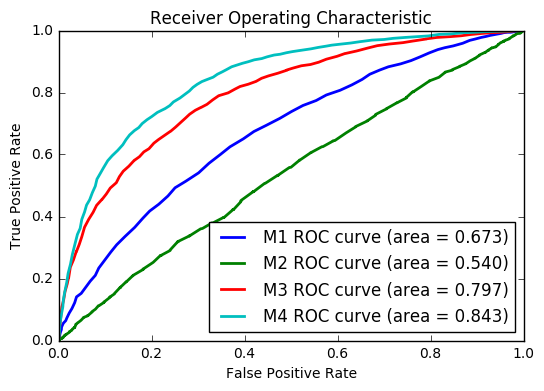

done


In [8]:
plt.figure()
plt.plot(fpr1, tpr1, lw=2)
plt.plot(fpr2, tpr2, lw=2)
plt.plot(fpr3, tpr3, lw=2)
plt.plot(fpr4, tpr4, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(['M1 ROC curve (area = %0.3f)' % roc_auc1, 'M2 ROC curve (area = %0.3f)' % roc_auc2, \
            'M3 ROC curve (area = %0.3f)' % roc_auc3, 'M4 ROC curve (area = %0.3f)' % roc_auc4], loc='best')
plt.show()
print ("done")


In [62]:
with open("google_wordmap.pickle", "rb") as input_file:
   word_centroid_map2 = pickle.load(input_file)

Testing the classifiers on test data...

In [63]:
# testing the classifiers on test data and sending score to Kaggle

X1_for_test = np.zeros( (test["review"].size, 10), dtype="float32" )
counter = 0
for review in clean_test_reviews:
    X1_for_test[counter] = create_bag_of_centroids( review, word_centroid_map1 )
    counter += 1
with open('pickle_X1_for_test', 'wb') as handle:
    pickle.dump(X1_for_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
X2_for_test = np.zeros( (test["review"].size, 10), dtype="float32" )
counter = 0
for review in clean_test_reviews:
    X2_for_test[counter] = create_bag_of_centroids( review, word_centroid_map2 )
    counter += 1
with open('pickle_X2_for_test', 'wb') as handle:
    pickle.dump(X2_for_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
X3_for_test = np.zeros((test['review'].size, 10), dtype="float32")
revSize1 = 0
for ctr in clean_test_reviews:
    vec1 = dictionary1.doc2bow(ctr)
    doc_lda1 = ldamodel1[vec1]
    for i in range(0,len(doc_lda1)):
        point1 = doc_lda1[i][0]
        X3_for_test[revSize1][point1] = doc_lda1[i][1]
    revSize1+=1

with open('pickle_X3_for_test', 'wb') as handle:
    pickle.dump(X3_for_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
X4_for_test = np.zeros((test['review'].size, 20), dtype="float32")
revSize2 = 0
for ctr in clean_test_reviews:
    vec2 = dictionary2.doc2bow(ctr)
    doc_lda2 = ldamodel2[vec2]
    for i in range(0,len(doc_lda2)):
        point2 = doc_lda2[i][0]
        X4_for_test[revSize2][point2] = doc_lda2[i][1]
    revSize2+=1
with open('pickle_X4_for_test', 'wb') as handle:
    pickle.dump(X4_for_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print ("Done")

Done


In [9]:
with open("pickle_X1_for_test", "rb") as input_file:
   X1_for_test = pickle.load(input_file)
with open("pickle_X2_for_test", "rb") as input_file:
   X2_for_test = pickle.load(input_file)
with open("pickle_X3_for_test", "rb") as input_file:
   X3_for_test = pickle.load(input_file)
with open("pickle_X4_for_test", "rb") as input_file:
   X4_for_test = pickle.load(input_file)
##################################  first RF model ################
print ("First Model")
M1.fit(X1,sen)
predicted1_test = M1.predict(X1_for_test)
output = pd.DataFrame( data={"id":test["id"], "sentiment":predicted1_test} )
output.to_csv( "M1.csv", index=False, quoting=3 )

##################################  second RF model ################
print ("Second Model")
M2.fit(X2,sen)
predicted2_test = M2.predict(X2_for_test)
output = pd.DataFrame( data={"id":test["id"], "sentiment":predicted2_test} )
output.to_csv( "M2.csv", index=False, quoting=3 )

##################################  third RF model ################
print ("Third Model")
M3.fit(X3,sen)
predicted3_test = M3.predict(X3_for_test)
output = pd.DataFrame( data={"id":test["id"], "sentiment":predicted3_test} )
output.to_csv( "M3.csv", index=False, quoting=3 )

##################################  fourth RF model ################
print ("Fourth Model")
M4.fit(X4,sen)
predicted4_test = M4.predict(X4_for_test)
output = pd.DataFrame( data={"id":test["id"], "sentiment":predicted4_test} )
output.to_csv( "M4.csv", index=False, quoting=3 )

print ("Done")

First Model
Second Model
Third Model
Fourth Model
Done


I have also used the above trained RF classifiers on the testing data-sets and sent the predictions to Kaggle. My scores are as shown below.
First model = 0.62096
Second model = 0.53784
Third model = 0.71896
Fourth model = 0.74872

In general, the accuracies on the testing data sets are lower than on training which is obvious. However, here too, the 20 topics LDA model is performing the best and the Google model the worst.

CONCLUSION

On the whole, the LDA model with 20 topics is performing the best. This is however, worse than the simple bag of words approach used in the first assignment which gave high results such as 0.88-0.90. This could be because bag of words model does not take into consideration grammar or word order and is built using the words in each of the reviews itself.

Techniques to improve efficacy of the classifiers are:
1. Increasing the number of topics used in the LDA models. After all, the number of topics is the number of features and increasing the number of features is a way to improve accuracy of machine learning models. With such a vast sized data set, 10 and 20 features will indeed be less and not accurately demonstrate the similarity between words.
2. Increasing the number of clusters used during K means clustering. With more number of clusters, more similar words are grouped together better and thus have a better indication at which words are alike.
3. Classifier tuning can always be done to better its performance. By including the maximum depth of the tree or the minimum number of samples required to be a leaf node or even weighting the trees to perform a sort of boot strapping, the accuracy of the model could have been improved. Even tuning the previous models like the LDA model could result in better performance.